In [1]:
from webbrowser import BaseBrowser
import pandas as pd
import os
import numpy as np

benchmarkVersion = "test-all-2025-09-29/run"

rootDir = "/workspaces/promptpex/"

if not os.path.isdir(rootDir):
    rootDir = "../"

evalsDir = f'{rootDir}/evals/{benchmarkVersion}/'

benchmarks = [ "speech-tag"]

# full set
benchmarks = [ "speech-tag", "classify-input-text", "text-to-p",  "sentence-rewrite", "extract-names", "elements", "art-prompt", "shakespearean-writing-assistant"]
# benchmarks = [ "speech-tag", "text-to-p",  "sentence-rewrite", "extract-names", "elements", "art-prompt", "shakespearean-writing-assistant"]

# benchmarks = [ "speech-tag", "classify-input-text", "text-to-p",  "sentence-rewrite", "elements", "art-prompt", "shakespearean-writing-assistant"]


#benchmarks = [ "speech-tag", "text-to-p", "elements", "extract-names", ]

#benchmarks = [  "speech-tag", "text-to-p",  ]

#benchmarks = [ "speech-tag",  ]

#benchmarks = [ "speech-tag", "text-to-p",  "sentence-rewrite", "extract-names", "elements", "art-prompt",  "shakespearean-writing-assistant"]

#benchmarks = [ "speech-tag", "text-to-p", "sentence-rewrite", "extract-names", "elements", "art-prompt", "classify-input-text"   ]
# benchmarks = [ "speech-tag", "text-to-p", "sentence-rewrite", "extract-names", "elements",    ]
#benchmarks = [ "speech-tag", "text-to-p", ]


prettyNames = { "speech-tag": "speech-tag", 
                "text-to-p": "text-to-p",  
                "shakespearean-writing-assistant": "shakespeare", 
                "sentence-rewrite": "sentence", 
                "extract-names": "extract-names", 
                "elements":"elements", 
                "art-prompt": "art-prompt", 
                "classify-input-text": "classify"}


benchmarks = [ "speech-tag", "classify-input-text", "text-to-p",  "sentence-rewrite", "extract-names", "elements", "art-prompt", 
"sewing_951_7",
"hearing_impairments_124_7",
"speaker_identification_595_2",
"real_time_analytics_609_2",
"housing_market_dynamics_338_1",]

benchmarks = [ "speech-tag",  ]

benchmarks = [
"crewai_assistant_qqtuuwsby",
"fragrance_finder_deluxe_e9avvjxcw",
"information_kiosk_building_j6ry5iscb",
"thread_weaver_krog0f5tg",
"hurtig_ingeni_r_pgktzdcfk",

    "speech-tag",
    "text-to-p",
    "elements",
    "art-prompt",
    "extract-names",
    "classify-input-text",
    "sentence-rewrite",
    "shakespearean-writing-assistant",
"architect_guide_for_programmers",
"unconstrained_ai_model_dan",
"idea_clarifier_gpt",
"structured_iterative_reasoning_protocol_sirp",
"tech_challenged_customer",

"learning_coach",
"writing_editor",
"coding_partner",
"brainstormer",
"career_guide",

"synonym_finder",
"instructor_in_a_school",
"dev_helper_upyxwdlcg",
"url_to_business_plan_a3znu5fsn",
"prompt_creator_8ope0amfj"
];


### Add proper columns to the dataframe

data = {}
comp_val = {}
base_comp_val = {}
pos_comp_val = {}
neg_comp_val = {}

# Track benchmarks with negative tests for filtering
benchmarks_with_neg_tests = []
benchmarks_without_neg_tests = []

for benchmark in benchmarks:
    print("benchmark: ", benchmark)
    data[benchmark] = pd.read_csv(f'{evalsDir}/{benchmark}/{benchmark}/overview.csv')
    db = data[benchmark]

    if "tests negative" in db.columns:
        if db["tests negative"][0] == 0:
            print("No negative tests for: ", benchmark)
            benchmarks_without_neg_tests.append(benchmark)
        else:
            benchmarks_with_neg_tests.append(benchmark)
    else:
        db["tests negative"] = 0
        benchmarks_without_neg_tests.append(benchmark)
        
    db["compliant %"] = [float(p.strip('%')) / 100 for p in db["tests compliant"]]
    # db["compliant %"] = 0
    # Check if "baseline compliant" column exists before using it
    if "baseline compliant" in db.columns:
        db["baseline %"] = [float(p.strip('%')) / 100 for p in db["baseline compliant"]]
    else:
        db["baseline %"] = 0
    db["pos rule %"] = db["tests positive compliant"] / db["tests positive"]
    
    # Handle division by zero for negative rules
    if db["tests negative"][0] > 0:
        db["neg rule %"] = db["tests negative compliant"] / db["tests negative"]
    else:
        db["neg rule %"] = np.nan  # Use NaN for benchmarks with no negative tests
        
    db["valid test %"] = db["tests valid"] / db["tests"]
    # db["pos rule %"] = 0
    # db["neg rule %"] = 0
    # db["valid test %"] = 0
    
    comp_val[benchmark] = db["compliant %"]
    base_comp_val[benchmark] = db["baseline %"]
    pos_comp_val[benchmark] = db["pos rule %"]
    neg_comp_val[benchmark] = db["neg rule %"]

    
    print(db["compliant %"])
    print(db["baseline %"])
    print(db["pos rule %"])
    print(db["neg rule %"])
    print(db["valid test %"])

# Print warning about benchmarks with 0 negative tests
if benchmarks_without_neg_tests:
    print("\n" + "="*60)
    print("WARNING: The following benchmarks have 0 negative tests:")
    for benchmark in benchmarks_without_neg_tests:
        print(f"  - {benchmark}")
    print("These benchmarks will be excluded from negative rule compliance calculations.")
    print("="*60 + "\n")

# zero out the sum
n_models = len(data[benchmarks[0]]["model"])
comp_val["sum"] = [0 for i in range(n_models)]
base_comp_val["sum"] = [0 for i in range(n_models)]
pos_comp_val["sum"] = [0 for i in range(n_models)]
neg_comp_val["sum"] = [0 for i in range(n_models)]

# sum up the values across the benchmarks
for key in comp_val:
    if (key != "sum"):
        print("key:", key)
        comp_val["sum"] = comp_val["sum"] + comp_val[key]
        base_comp_val["sum"] = base_comp_val["sum"] + base_comp_val[key]
        pos_comp_val["sum"] = pos_comp_val["sum"] + pos_comp_val[key]
        # Only sum negative values for benchmarks that have negative tests
        if key in benchmarks_with_neg_tests:
            neg_comp_val["sum"] = neg_comp_val["sum"] + neg_comp_val[key]
        # print('neg_comp_val["sum"]', neg_comp_val["sum"])

# calculate the mean
#print('comp_val["sum"]', comp_val["sum"])
comp_val["mean"] = comp_val["sum"]/len(benchmarks)
#print('comp_val["mean"]', comp_val["mean"])
base_comp_val["mean"] = base_comp_val["sum"]/len(benchmarks)
pos_comp_val["mean"] = pos_comp_val["sum"]/len(benchmarks)
#print('neg_comp_val["sum"]', neg_comp_val["sum"])
# Calculate mean only for benchmarks with negative tests
if len(benchmarks_with_neg_tests) > 0:
    neg_comp_val["mean"] = neg_comp_val["sum"]/len(benchmarks_with_neg_tests)
else:
    neg_comp_val["mean"] = [np.nan for i in range(n_models)]
#print('neg_comp_val["mean"]', neg_comp_val["mean"])
    
    
###############################################################################
### Generate graphs from the data


### Generate a csv with the non compliance % per benchmark for promptpex
###
    
with open(f'{evalsDir}/pp-cpct.csv', 'w') as cfile:
    print("Benchmark,", end="", file=cfile)
    # just need the model names from the first benchmark
    db = data[benchmarks[0]] 
    print(', '.join(map(str, db["model"])), file=cfile)
        
    for benchmark in benchmarks:
        name = prettyNames.get(benchmark, benchmark)
        print(name, ",", end="", file=cfile)
        db = data[benchmark]
        print(', '.join(map(str, (1-db["compliant %"]))), file=cfile)
    
    print("average", ",", end="", file=cfile)
    print(', '.join(map(str, (1-comp_val["mean"]))), file=cfile)

### Generate a csv with the test validity per benchmark for promptpex
###
  
with open(f'{evalsDir}/pp-test-validity.csv', 'w') as cfile:
    print("Benchmark, tests, valid tests", file=cfile)
        
    for benchmark in benchmarks:
        name = prettyNames.get(benchmark, benchmark)
        db = data[benchmark]
        print(f'{name},{db["tests"][0]}, {db["tests valid"][0]}', file=cfile)

### Generate a csv comparing positive and negative compliance per model and benchmark for promptpex
### Only include benchmarks that have negative tests
###

with open(f'{evalsDir}/pos-neg-cpct.csv', 'w') as cfile:
    
    models = data[benchmarks[0]]["model"]
    pos_sum = [0 for i in range(len(models))]
    neg_sum = [0 for i in range(len(models))]    
    
    print("Model, Rule % Non-Compliance, Inv Rule % Non-Compliance", file=cfile)

    # Only process benchmarks that have negative tests
    for b in benchmarks_with_neg_tests:
        db = data[b]
        # print(f'benchmark:{benchmark}, {db["neg rule %"]}')
        pos_sum += db["pos rule %"]
        neg_sum += db["neg rule %"]
    
    # Only output results if we have benchmarks with negative tests        
    if len(benchmarks_with_neg_tests) > 0:
        for m, psum, nsum in zip(models, pos_sum, neg_sum):
            print(m, ",", (1-psum/len(benchmarks_with_neg_tests)), ",", (1-nsum/len(benchmarks_with_neg_tests)), file=cfile)
        
    #print("average", ",", end="", file=cfile)
    #print(pos_comp_val["mean"], ",", neg_comp_val["mean"], file=cfile)

### Generate a csv with the average compliance of promptpex versus baseline
# each row is a model
# each column is a method (pp vs baseline)

with open(f'{evalsDir}/pp-compare.csv', 'w') as cfile:
    
    models = data[benchmarks[0]]["model"]
    pp_sum = [0 for i in range(len(models))]
    bl_sum = [0 for i in range(len(models))]    
    
    print("Model, PromptPex % Non-Compliance, Baseline % Non-Compliance", file=cfile)

    for b in benchmarks:
        db = data[b]
        #print(db["pos rule %"])
        pp_sum += db["compliant %"]
        bl_sum += db["baseline %"]
            
    for m, psum, bsum in zip(models, pp_sum, bl_sum):
        print(m, ",", (1-psum/len(benchmarks)), ",", (1-bsum/len(benchmarks)), file=cfile)

benchmark:  crewai_assistant_qqtuuwsby
0    0.60
1    0.05
2    0.40
3    0.05
Name: compliant %, dtype: float64
0    0.60
1    0.05
2    0.40
3    0.05
Name: baseline %, dtype: float64
0    0.588235
1    0.058824
2    0.411765
3    0.058824
Name: pos rule %, dtype: float64
0    0.666667
1    0.000000
2    0.333333
3    0.000000
Name: neg rule %, dtype: float64
0    0.95
1    0.95
2    0.95
3    0.95
Name: valid test %, dtype: float64
benchmark:  fragrance_finder_deluxe_e9avvjxcw
No negative tests for:  fragrance_finder_deluxe_e9avvjxcw
0    0.80
1    0.25
2    0.65
3    0.45
Name: compliant %, dtype: float64
0    0.80
1    0.25
2    0.65
3    0.45
Name: baseline %, dtype: float64
0    0.80
1    0.25
2    0.65
3    0.45
Name: pos rule %, dtype: float64
0   NaN
1   NaN
2   NaN
3   NaN
Name: neg rule %, dtype: float64
0    0.5
1    0.5
2    0.5
3    0.5
Name: valid test %, dtype: float64
benchmark:  information_kiosk_building_j6ry5iscb
0    0.22
1    0.06
2    0.33
3    0.00
Name: compli

In [2]:
### Extract out number of rules and grounded rules per benchmark

import os

grules = {}

if True:
    with open(f'{evalsDir}/pp-grounded-rules.csv', 'w') as cfile:
        print(f"benchmark, rules, grounded rules", file=cfile)
        for benchmark in benchmarks:
            # Read the rules.txt file and count lines
            rules_file_path = f'{evalsDir}/{benchmark}/{benchmark}/rules.txt'
            if os.path.exists(rules_file_path):
                with open(rules_file_path, 'r') as file:
                    lines = file.readlines()
                    # Count non-empty lines
                    rule_count = len([line for line in lines if line.strip()])
            else:
                rule_count = 0
                print(f"Warning: {rules_file_path} not found")
            
            name = prettyNames.get(benchmark, benchmark)
            # Using rule_count for both rules and grounded rules since we're just counting lines
            print(f"{name}, {rule_count}, {rule_count}", file=cfile)

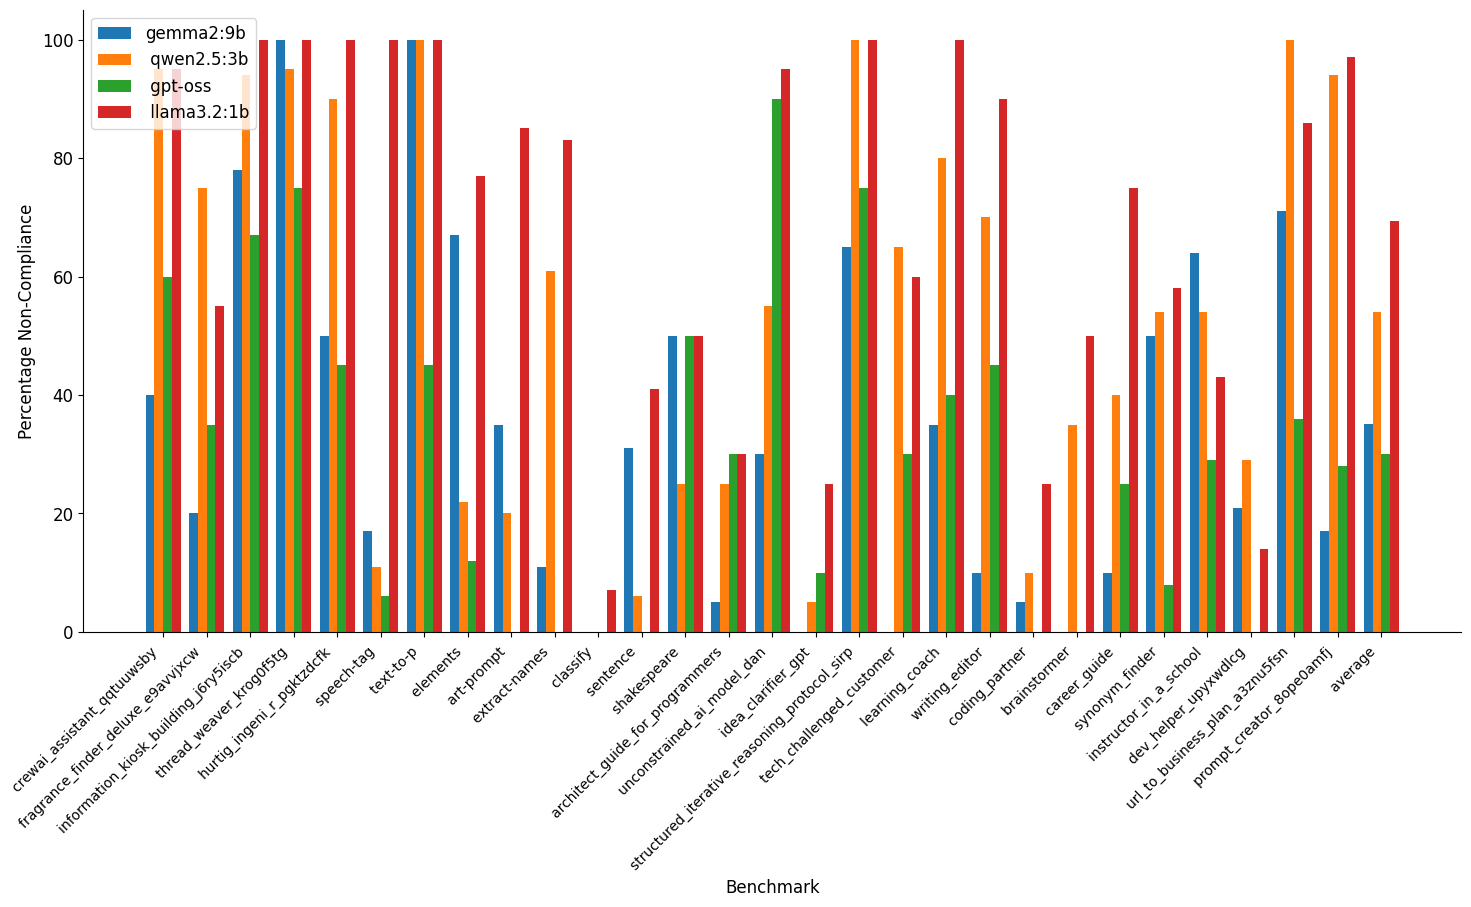

In [3]:
import matplotlib.pyplot as plt
import numpy as np


plt.rcParams.update({'font.size': 12}) 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False

# Load the CSV file into a DataFrame
df = pd.read_csv(f'{evalsDir}/pp-cpct.csv')

# Remove the 'average' row if present
df = df[df['Benchmark'] != 'average']

# Set the 'Benchmark' column as the index
df.set_index('Benchmark', inplace=True)

# Plotting with larger figure size to accommodate labels
fig, ax = plt.subplots(figsize=(15, 8))

# Number of benchmarks
n_benchmarks = len(df.index)
# Number of models
n_models = len(df.columns)

# Bar width
bar_width = 0.2

# Positions of the bars on the x-axis
indices = np.arange(n_benchmarks)

# Plot each model's bars
for i, model in enumerate(df.columns):
    ax.bar(indices + i * bar_width, df[model] * 100, bar_width, label=model)

# Set the x-axis labels with better formatting
ax.set_xticks(indices + bar_width * (n_models - 1) / 2)
ax.set_xticklabels(df.index, rotation=45, ha='right', fontsize=10)

# Set labels and title
ax.set_xlabel('Benchmark')
ax.set_ylabel('Percentage Non-Compliance')
# ax.set_title('Clustered Bar Chart of Benchmark % Non-Compliance by Model')
ax.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Add extra space at bottom for rotated labels
plt.savefig(f'{evalsDir}/pp-cpct.pdf', bbox_inches='tight')
plt.show()

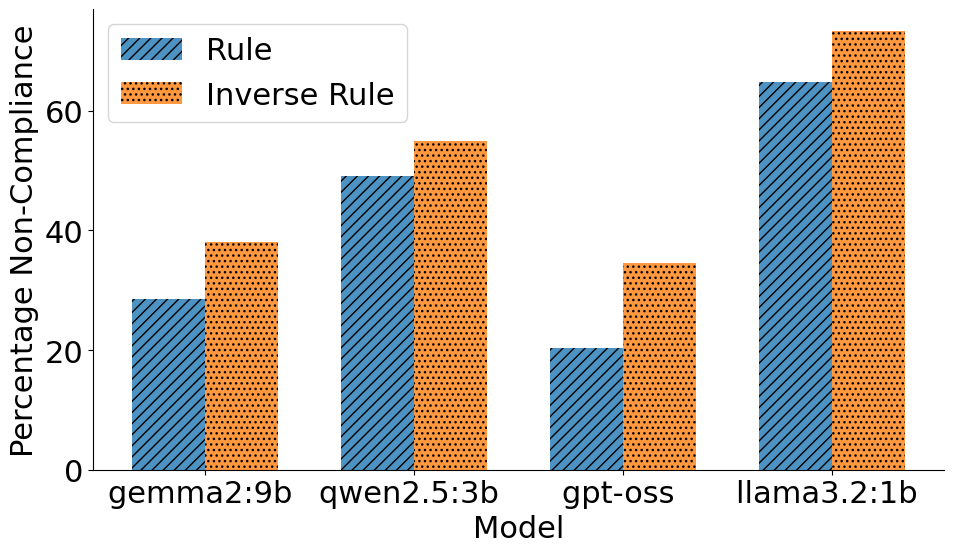

In [4]:
# Load the CSV file into a DataFrame
df = pd.read_csv(f'{evalsDir}/pos-neg-cpct.csv')

# Filter out models/rows where inverse rule non-compliance is NaN or where there were no negative tests
# This happens when a benchmark has 0 negative tests
df_filtered = df.dropna(subset=[' Inv Rule % Non-Compliance'])
df_filtered = df_filtered[df_filtered[' Inv Rule % Non-Compliance'] != 1.0]  # Remove entries where inverse rule compliance is 0% (1.0 non-compliance)

plt.rcParams.update({'font.size': 22}) 
# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.35

# Positions of the bars on the x-axis
indices = range(len(df_filtered))

# Plot each compliance type's bars with different hatch patterns for accessibility
ax.bar(indices, df_filtered[' Rule % Non-Compliance'] * 100, bar_width, 
       label='Rule', hatch='///', alpha=0.8)
ax.bar([i + bar_width for i in indices], df_filtered[' Inv Rule % Non-Compliance'] * 100, bar_width, 
       label='Inverse Rule', hatch='...', alpha=0.8)

# Set the x-axis labels
ax.set_xticks([i + bar_width / 2 for i in indices])
ax.set_xticklabels(df_filtered['Model'], rotation=0, ha='center')

# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Percentage Non-Compliance')
# ax.set_title('Rule % Non-Compliance and Inverse Rule % Non-Compliance by Model')
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig(f'{evalsDir}/pos-neg-cpct.pdf')
plt.show()

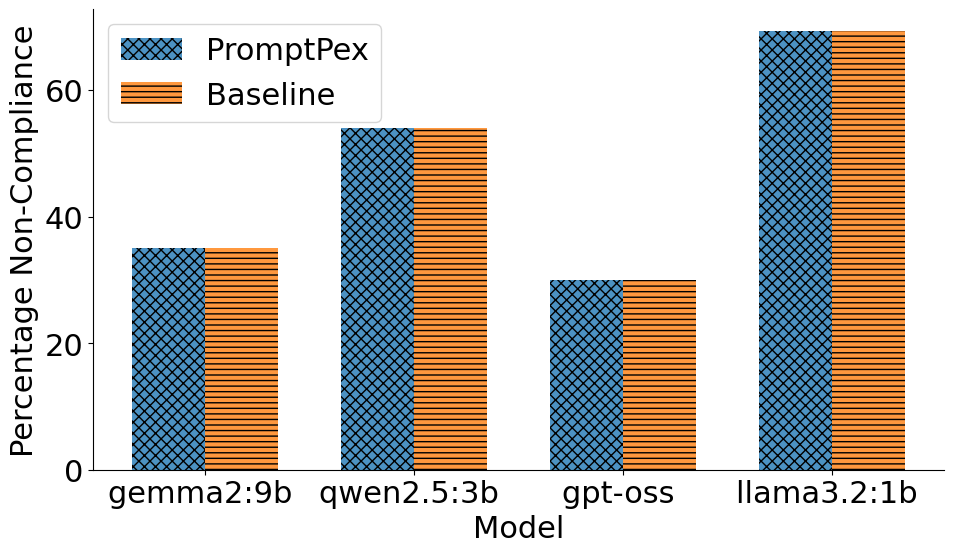

In [5]:
# Load the CSV file into a DataFrame
df = pd.read_csv(f'{evalsDir}/pp-compare.csv')

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

# Bar width
bar_width = 0.35

# Positions of the bars on the x-axis
indices = range(len(df))

# Plot each compliance type's bars with different hatch patterns for accessibility
ax.bar(indices, df[' PromptPex % Non-Compliance'] * 100, bar_width, 
       label='PromptPex', hatch='xxx', alpha=0.8)
ax.bar([i + bar_width for i in indices], df[' Baseline % Non-Compliance'] * 100, bar_width, 
       label='Baseline', hatch='---', alpha=0.8)

# Set the x-axis labels
ax.set_xticks([i + bar_width / 2 for i in indices])
ax.set_xticklabels(df['Model'], rotation=0, ha='center')

# Set labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Percentage Non-Compliance')
# ax.set_title('PromptPex % Non-Compliance and Baseline % Non-Compliance by Model')
ax.legend()

# Show the plot
plt.tight_layout()
plt.savefig(f'{evalsDir}/pp-compare.pdf')
# plt.show()

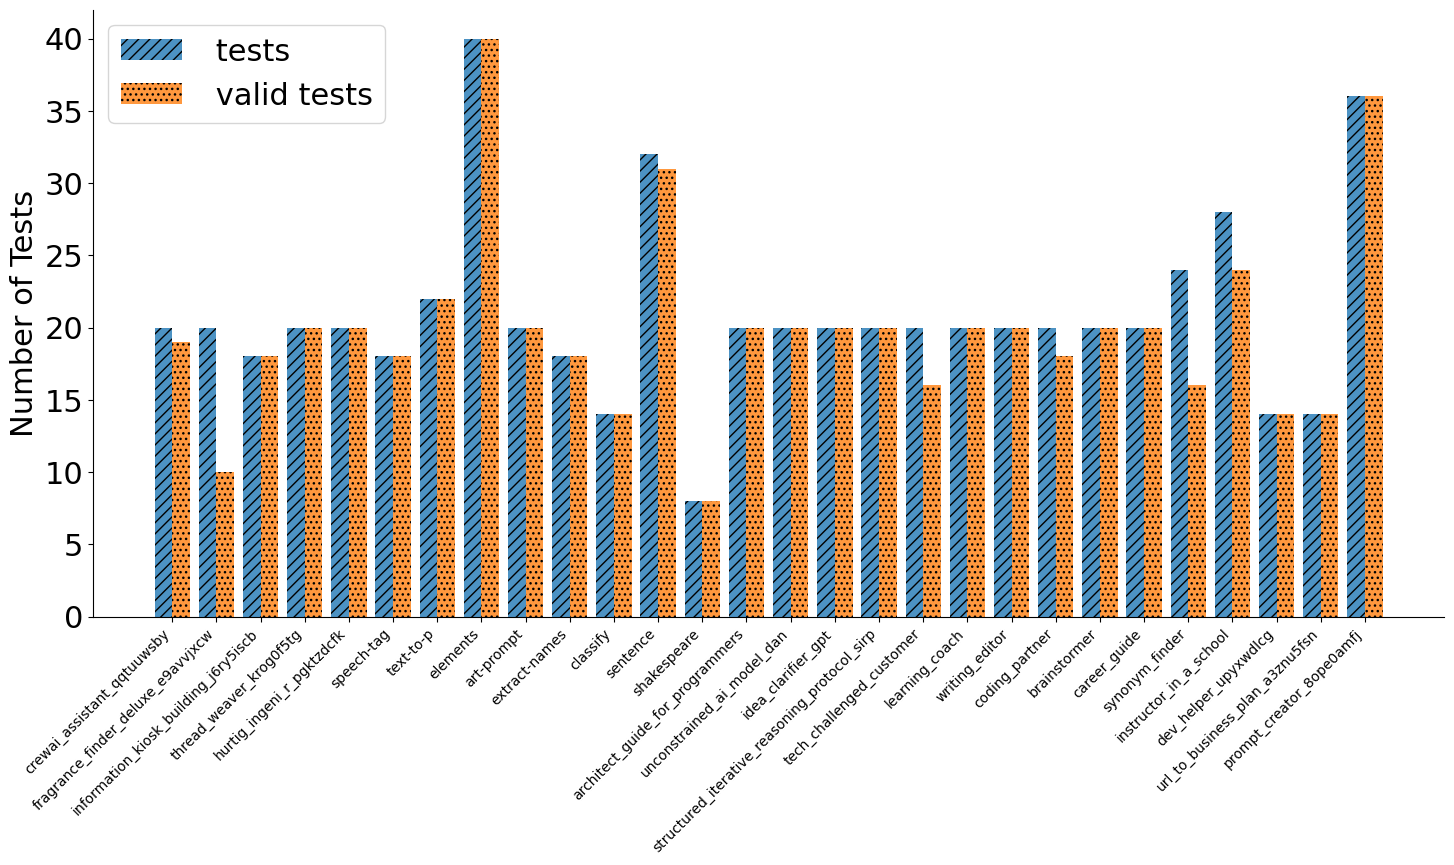

In [6]:
# Read the CSV file
df = pd.read_csv(f'{evalsDir}/pp-test-validity.csv')

# Plot the bar chart with hatch patterns for accessibility
fig, ax = plt.subplots(figsize=(15, 8))  # Increased figure size

# Get the columns to plot (excluding 'Benchmark')
plot_columns = [col for col in df.columns if col != 'Benchmark']

# Define different hatch patterns for each column
hatch_patterns = ['///', '...', 'xxx', '---', '+++', '|||', 'ooo', '***']

# Create a grouped bar chart
n_benchmarks = len(df)
n_columns = len(plot_columns)
bar_width = 0.8 / n_columns
x_positions = range(n_benchmarks)

# Plot each column with a different hatch pattern
for i, col in enumerate(plot_columns):
    hatch_pattern = hatch_patterns[i % len(hatch_patterns)]
    x_offset = [x + (i - (n_columns-1)/2) * bar_width for x in x_positions]
    ax.bar(x_offset, df[col], width=bar_width, 
           label=col, hatch=hatch_pattern, alpha=0.8)

# Set x-axis labels with better formatting
ax.set_xticks(x_positions)
ax.set_xticklabels(df['Benchmark'], rotation=45, ha='right', fontsize=10)

ax.set_ylabel('Number of Tests')
# ax.set_title('PromptPex Tests vs Valid Tests by Benchmark')
ax.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Add extra space at bottom for rotated labels

# Show plot
plt.savefig(f'{evalsDir}/pp-test-validity.pdf', bbox_inches='tight')
plt.show()

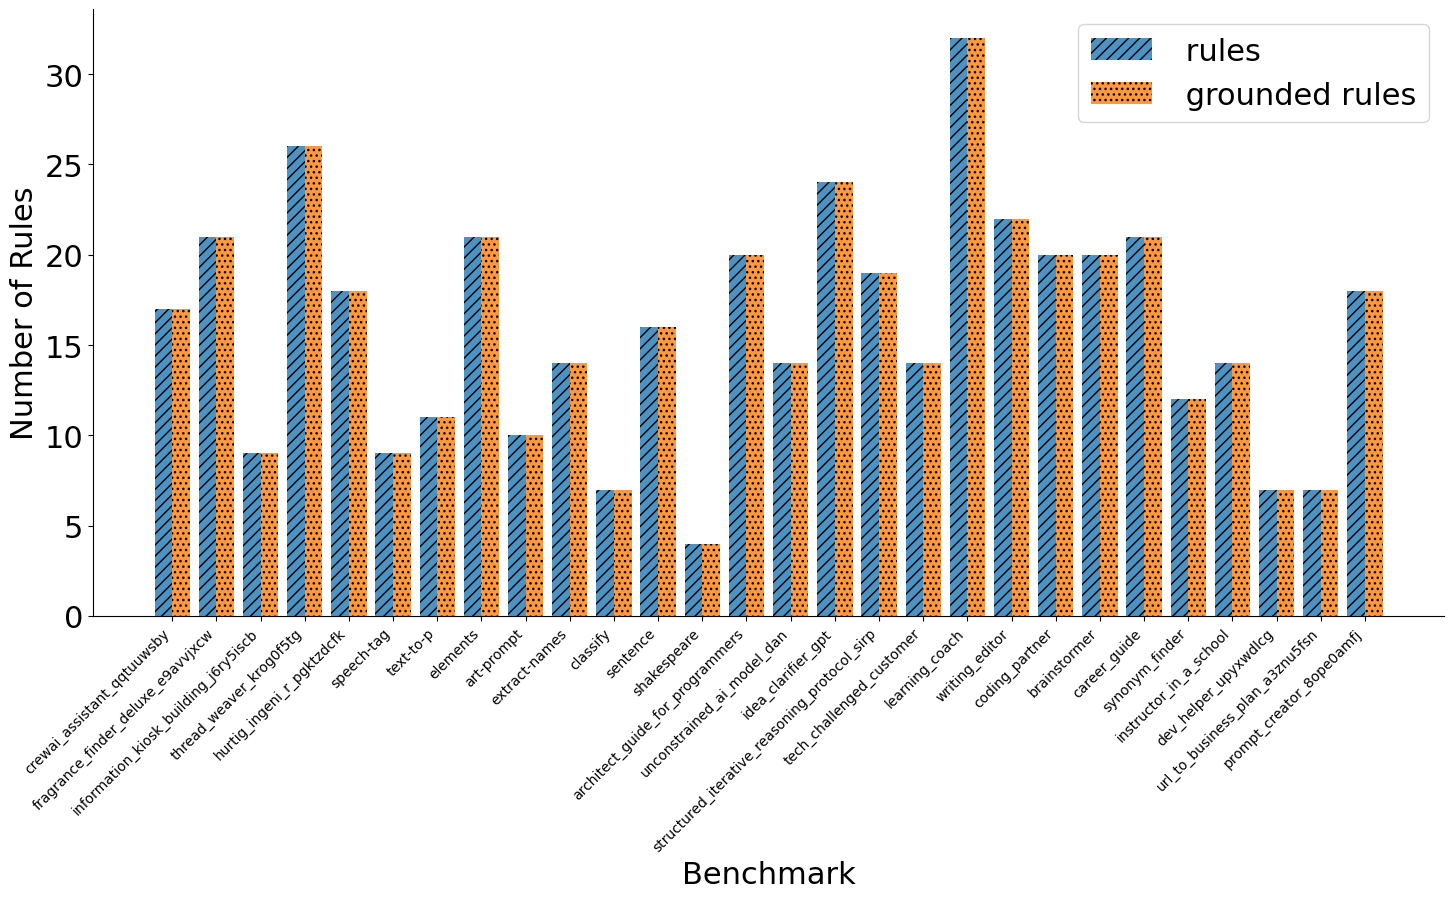

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
if True:
    df = pd.read_csv(f'{evalsDir}/pp-grounded-rules.csv')

    # Plot the bar chart with hatch patterns for accessibility
    fig, ax = plt.subplots(figsize=(15, 8))  # Increased figure size
    
    # Get the columns to plot (excluding 'benchmark')
    plot_columns = [col for col in df.columns if col != 'benchmark']
    
    # Define different hatch patterns for each column
    hatch_patterns = ['///', '...', 'xxx', '---', '+++', '|||']
    
    # Create a grouped bar chart
    n_benchmarks = len(df)
    n_columns = len(plot_columns)
    bar_width = 0.8 / n_columns
    x_positions = range(n_benchmarks)
    
    # Plot each column with a different hatch pattern
    for i, col in enumerate(plot_columns):
        hatch_pattern = hatch_patterns[i % len(hatch_patterns)]
        x_offset = [x + (i - (n_columns-1)/2) * bar_width for x in x_positions]
        ax.bar(x_offset, df[col], width=bar_width, 
               label=col, hatch=hatch_pattern, alpha=0.8)
    
    # Set x-axis labels with better formatting
    ax.set_xticks(x_positions)
    ax.set_xticklabels(df['benchmark'], rotation=45, ha='right', fontsize=10)
    
    ax.set_xlabel('Benchmark')
    ax.set_ylabel('Number of Rules')
    #ax.set_title('PromptPex Rules vs Grounded Rules by Benchmark')
    ax.legend()
    
    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)  # Add extra space at bottom for rotated labels

    # Show plot
    plt.savefig(f'{evalsDir}/pp-grounded-rules.pdf', bbox_inches='tight')
    plt.show()